In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_excel("./data/data_cn_lc.xlsx")
data = data.drop(columns=['Unnamed: 0'])
data.head()

,Company_name,Company_area,Company_code,Company_industry,CITI,CITI_all_rank,CITI_trade_rank,CATI,CATI_all_rank,CATI_trade_rank,...,rank_Assistant1,rank_Claude-instant0,rank_Claude-instant1,rank_Claude-instant2,rank_GPT-3.5-Turbo0,rank_GPT-3.5-Turbo1,rank_GPT-3.5-Turbo-Instruct0,rank_GPT-3.5-Turbo-Instruct1,rank_GPT-40,rank_Web-Search0
0,李宁有限公司,中国大陆,02331.HK,"纺织, 皮革",39.46,39,11,24.8,284,32,...,B,B-,B,B-,C,B,B,C+,C,-
1,联想集团有限公司,中国大陆,00992.HK,IT/ ICT,46.44,34,9,65.2,15,7,...,A,A-,A+,B,A,A,A,A-,B+,-
2,雅戈尔集团股份有限公司,中国大陆,600177.SH,纺织,6.40,531,108,7.0,929,117,...,C-,A,C+,B,C-,C-,C-,B-,C-,C
3,探路者控股集团股份有限公司,中国大陆,300005.SZ,"纺织, 皮革",2.00,647,59,2.5,1269,59,...,C,A+,C,C-,C-,C,D,D-,C-,-
4,青岛啤酒股份有限公司,中国大陆,600600.SH,啤酒,10.70,358,6,16.0,508,6,...,B+,A,A,A-,B,B,B+,B,B,B


In [4]:
ci_score = zip(data["Company_industry"].unique(), range(len(data["Company_industry"].unique())))
ci_score = dict(ci_score)
ci_score

{'纺织, 皮革': 0,
 'IT/ ICT': 1,
 '纺织': 2,
 '啤酒': 3,
 '汽车': 4,
 '汽车, 电池及电池材料': 5,
 'IT/ ICT, 光伏设备': 6,
 '乳制品': 7,
 '食品饮料': 8,
 '家电': 9,
 '日化': 10,
 '皮革': 11,
 '纸业': 12,
 'IT/ ICT, 家电': 13,
 '房地产建筑': 14,
 '食品饮料, 乳制品': 15,
 '纺织, 钢铁': 16,
 '汽车零部件': 17,
 '白酒': 18,
 '医药': 19,
 '家装': 20,
 '化工, 家装': 21,
 '家电, 家装': 22,
 '自行车/助力车': 23,
 '光伏设备': 24,
 '玩具': 25,
 '互联网平台': 26,
 '零售, 互联网平台': 27,
 '家电, 光伏设备': 28,
 '餐饮': 29}

In [5]:

index = np.random.choice(range(len(data)), size=len(data), replace=False)

In [6]:
index

array([ 24, 140,  53,  73,  18, 109,  70, 160,  66,  99, 120, 205, 161,
       184, 158, 169,   2,  72,  33, 150,  35,  29, 189,  19,  30, 113,
       122,   4, 136,  50, 126,  44, 172,  80, 142, 104,  85,   5, 204,
       114,  48, 200, 153,  62, 173,  22,  38, 166,  54, 152, 206, 139,
       103,  78, 171, 124, 111,  25, 181,  39, 179, 155,  41, 191,  90,
        74, 119, 121,  10,  95,  87, 135, 141, 178, 187, 177,  76, 198,
         8,  63,  86, 131, 188, 208,  52,  64,  71,  97, 149,  68,  59,
        84,  81, 194, 106, 148,  15, 209,  77,  42,  12, 128,  37, 133,
        79, 168, 156,  89, 210,   6, 202, 125,  45,  23,  34, 167,  55,
       117, 144, 134, 110, 159,  46, 157, 164, 203, 123,  28, 183,  31,
       170,  14,  61, 162, 213, 129, 107,  20,  47, 132,  49,  21, 186,
        94, 199,  17, 207,  16,  36,  92, 193, 100,   3, 175, 165, 214,
       196, 195,  26,  27,   7, 197,  98,  91,  82, 127, 145,  43,  69,
       211,   9, 185, 130,  93, 102, 116,  96,  67,  40, 143, 14

In [7]:
gt_environment = data["Environment"]

In [8]:
gt_environment = gt_environment.to_numpy()

In [9]:
np.unique(gt_environment)

array(['A', 'A+', 'A-', 'AA-', 'B', 'BB', 'BBB', 'BBB+', 'BBB-', 'C'],
      dtype=object)

In [10]:
gt_score = {"C":0, "B":1,"BB":2,"BBB-":3,"BBB":4,"BBB+":5,"A-":6,"A":7,"AA-":8,"A+":9}

In [11]:
pr_environment = data["rank_GPT-40"]

In [12]:
pr_environment = pr_environment.to_numpy()

In [13]:
np.unique(pr_environment)

array(['A', 'A+', 'A-', 'B', 'B+', 'B-', 'C', 'C+', 'C-', 'D', 'D+'],
      dtype=object)

In [14]:
pr_score = {"D":0,"D+":1,"C-":2,"C":3,"C+":4,"B-":5,"B":6,"B+":7,"A-":8,"A":9,"A+":10}

In [15]:
gt_esg = [gt_score[i] for i in gt_environment]

In [16]:
pr_esg = [pr_score[i] for i in pr_environment]

In [17]:
gt_esg = np.array(gt_esg)
pr_esg = np.array(pr_esg)

In [18]:
def re_histogram(esg):
    hist = []
    for i in range(0,int(esg.max())+1):
        hist = np.append(hist, np.sum(esg == i))
    re_hist = np.zeros(5)
    re_dict = {}
    partition = np.round(hist.sum()/5)
    index = 0
    for i,v in enumerate(hist):
        if v <= partition - re_hist[index]:
            re_hist[index] += v
            re_dict[i] = index
        else:
            if v + re_hist[index] > partition * 1.2:
                index += 1
                if index == 5:
                    index = 4
                    re_hist[index] += v
                    re_dict[i] = index
                else:
                    re_hist[index] += v
                    re_dict[i] = index
            else:
                re_hist[index] += v
                re_dict[i] = index
                index += 1
                if index == 5:
                    index = 4
    return re_dict

In [19]:
gt_hist = re_histogram(gt_esg)
pr_hist = re_histogram(pr_esg)

In [20]:
re_gt_esg = [gt_hist[i] for i in gt_esg]
re_pr_esg = [pr_hist[i] for i in pr_esg]
re_pr_esg = np.array(re_pr_esg)
re_gt_esg = np.array(re_gt_esg)

In [21]:
np.where(re_gt_esg==re_pr_esg)[0].shape[0]/re_gt_esg.shape[0]

0.2837209302325581

In [26]:
np.where(gt_esg==pr_esg-1)[0].shape[0]/re_gt_esg.shape[0]

0.08372093023255814

In [27]:
np.where(gt_esg==pr_esg+1)[0].shape[0]/re_gt_esg.shape[0]

0.046511627906976744

In [28]:
np.where(gt_esg==pr_esg)[0].shape[0]/re_gt_esg.shape[0]

0.08837209302325581

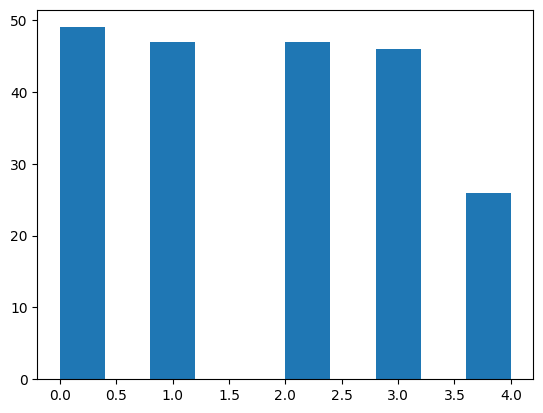

In [68]:
gt_dis = plt.hist(re_gt_esg)[0]

In [31]:
gt_dis

array([49., 47., 47., 15., 19., 12.,  6., 11.,  4.,  5.])

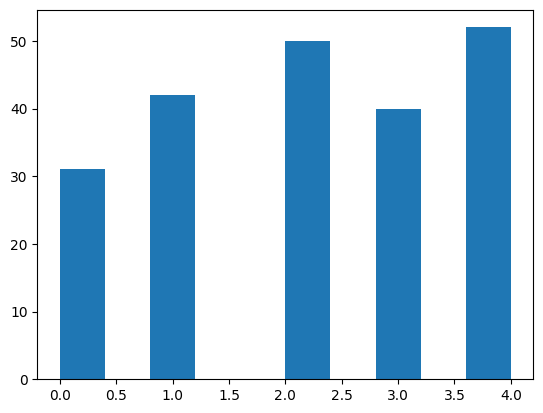

In [69]:
pr_dis =plt.hist(re_pr_esg)[0]

In [29]:
len(np.where(gt_esg == pr_esg)[0])

45

In [30]:
45/len(gt_esg)

0.20930232558139536

In [31]:
def cross_entropy(y, t):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta))

In [43]:
cross_entropy(pr_dis, gt_dis)

-629.4559202993247

In [49]:
len(np.where(gt_esg == pr_esg+1)[0])

16

In [50]:
len(np.where(gt_esg == pr_esg-1)[0])

24

In [51]:
(45+16+24)/len(gt_esg)

0.3953488372093023

In [52]:
pr_score = {"N/":0,"E":0,"D-":0,"D":0, "C-":0, "C":0, "C+":0,"B-":1,"B":1,"B+":1,"A-":2,"A":2,"A+":2}
gt_score = {"C":0, "B":0,"BB":0,"BBB⁻":1,"BBB":1,"BBB⁺":1,"A⁻":2,"A":2,"AA⁻":2,"A⁺":2}

In [53]:
gt_esg = [gt_score[i] for i in gt_environment]
pr_esg = [pr_score[i] for i in pr_environment]

In [54]:
gt_esg = np.array(gt_esg)
pr_esg = np.array(pr_esg)

In [58]:
len(np.where(gt_esg == pr_esg)[0])/len(gt_esg)+len(np.where(gt_esg == pr_esg+1)[0])/len(gt_esg)+len(np.where(gt_esg == pr_esg-1)[0])/len(gt_esg)

0.8883720930232558

In [56]:
len(np.where(gt_esg == pr_esg+1)[0])/len(gt_esg)

0.12093023255813953

In [57]:
len(np.where(gt_esg == pr_esg-1)[0])/len(gt_esg)

0.2930232558139535